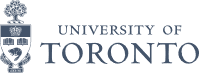

# Session 4a: Anomaly Detecction

For additional information please go to:

https://www.kaggle.com/code/roblexnana/understanding-auto-encoder-on-mnist-digit-dataset

https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders

# Table of Contents
1. Unsupervise learning
2. Preprocessing
3. Visualising t-SNE (t-distributed stochastic neighbor embedding)
4. Train/Validate/Test split
5. Training the auto-encoder

# Unsupervised Learning with Auto-Encoders

If you are interested in an introduction to auto-encoders, head over to [Julien Despois' article](https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df).
If a more technical breakdown is what you are looking for, check out [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) from which the below image is sourced.
It illustrates the functioning of an auto-encoder for MNIST images, but the concept is the same.

![image.png](attachment:image.png)

The idea is quite straightforward:
1. Due to the **bottleneck architecture** of the neural network, it is forced to learn a **condensed representation** from which to reproduce the original input.
2. We feed it **only normal transactions**, which it will learn to reproduce with high fidelity.
3. As a consequence, if a **fraud transaction is sufficiently distinct** from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent **reconstruction loss will be high**.
4. Anything above a specific loss (treshold) will be **flagged as anomalous** and thus labeled as fraud.

<a id="2"></a> <br>


# Preprocessing

## Import packages



```
# read & manipulate data
import pandas as pd
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import pylab as plt
#%matplotlib notebook

# misc
import random as rn
```



In [1]:
# read & manipulate data
import pandas as pd
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import pylab as plt
# %matplotlib notebook

# misc
import random as rn

## Load dataset



```
# load the dataset
df = pd.read_csv('https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv',sep=',')
```



In [2]:
# load the dataset
df = pd.read_csv('https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv',sep=',')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Setting seeds for reproducibility








```
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) #
```



In [4]:
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Exploratory analysis
Extracted from Kaggle
`https://www.kaggle.com/code/chocojh/starter-credit-card-fraud-detection-249b5984-4`

In [5]:
#@title Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis=1)
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

Now you're ready to read in the data and use the plotting functions to visualize the data.

In [6]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# creditcard.csv has 284807 rows in reality, but we are only loading/previewing the first 1000 rows
#df1 = pd.read_csv('/kaggle/input/creditcard.csv', delimiter=',', nrows = nRowsRead)
df1 = df
#df1.dataframeName = 'creditcard.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 284807 rows and 31 columns


Let's take a quick look at what the data looks like:

In [7]:
df1.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0




```
Label_df=df1['Class']
plt.hist(Label_df)
plt.show()
print('Number of cases non Fraud: ' + str(np.sum(Label_df==0)))
print('Number of cases Fraud: ' + str(np.sum(Label_df==1)))
```



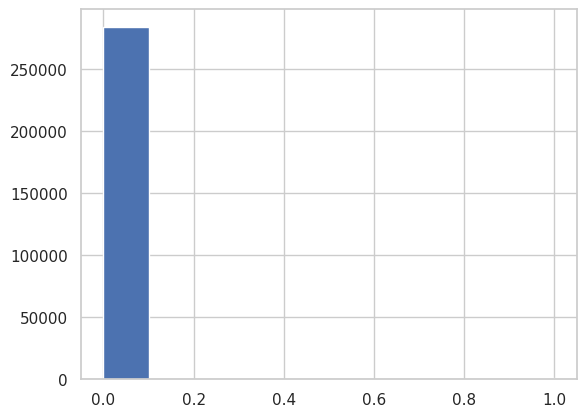

Number of cases non Fraud: 284315
Number of cases Fraud: 492


In [8]:
Label_df = df1['Class']
plt.hist(Label_df)
plt.show()
print('Number of cases non Fraud: ' + str(np.sum(Label_df==0)))
print('Number of cases Fraud: ' + str(np.sum(Label_df==1)))



```
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

corr=df1.corr();
fig = px.imshow(np.round(corr,2), text_auto=True)
fig.update_layout(autosize=False,width=700,height=700)
fig.show()
```



In [9]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

corr = df1.corr()
fig = px.imshow(np.round(corr,2), text_auto=True)
fig.update_layout(autosize=False,width=700,height=700)
fig.show()



```
plotScatterMatrix(df1, 20, 10)
```



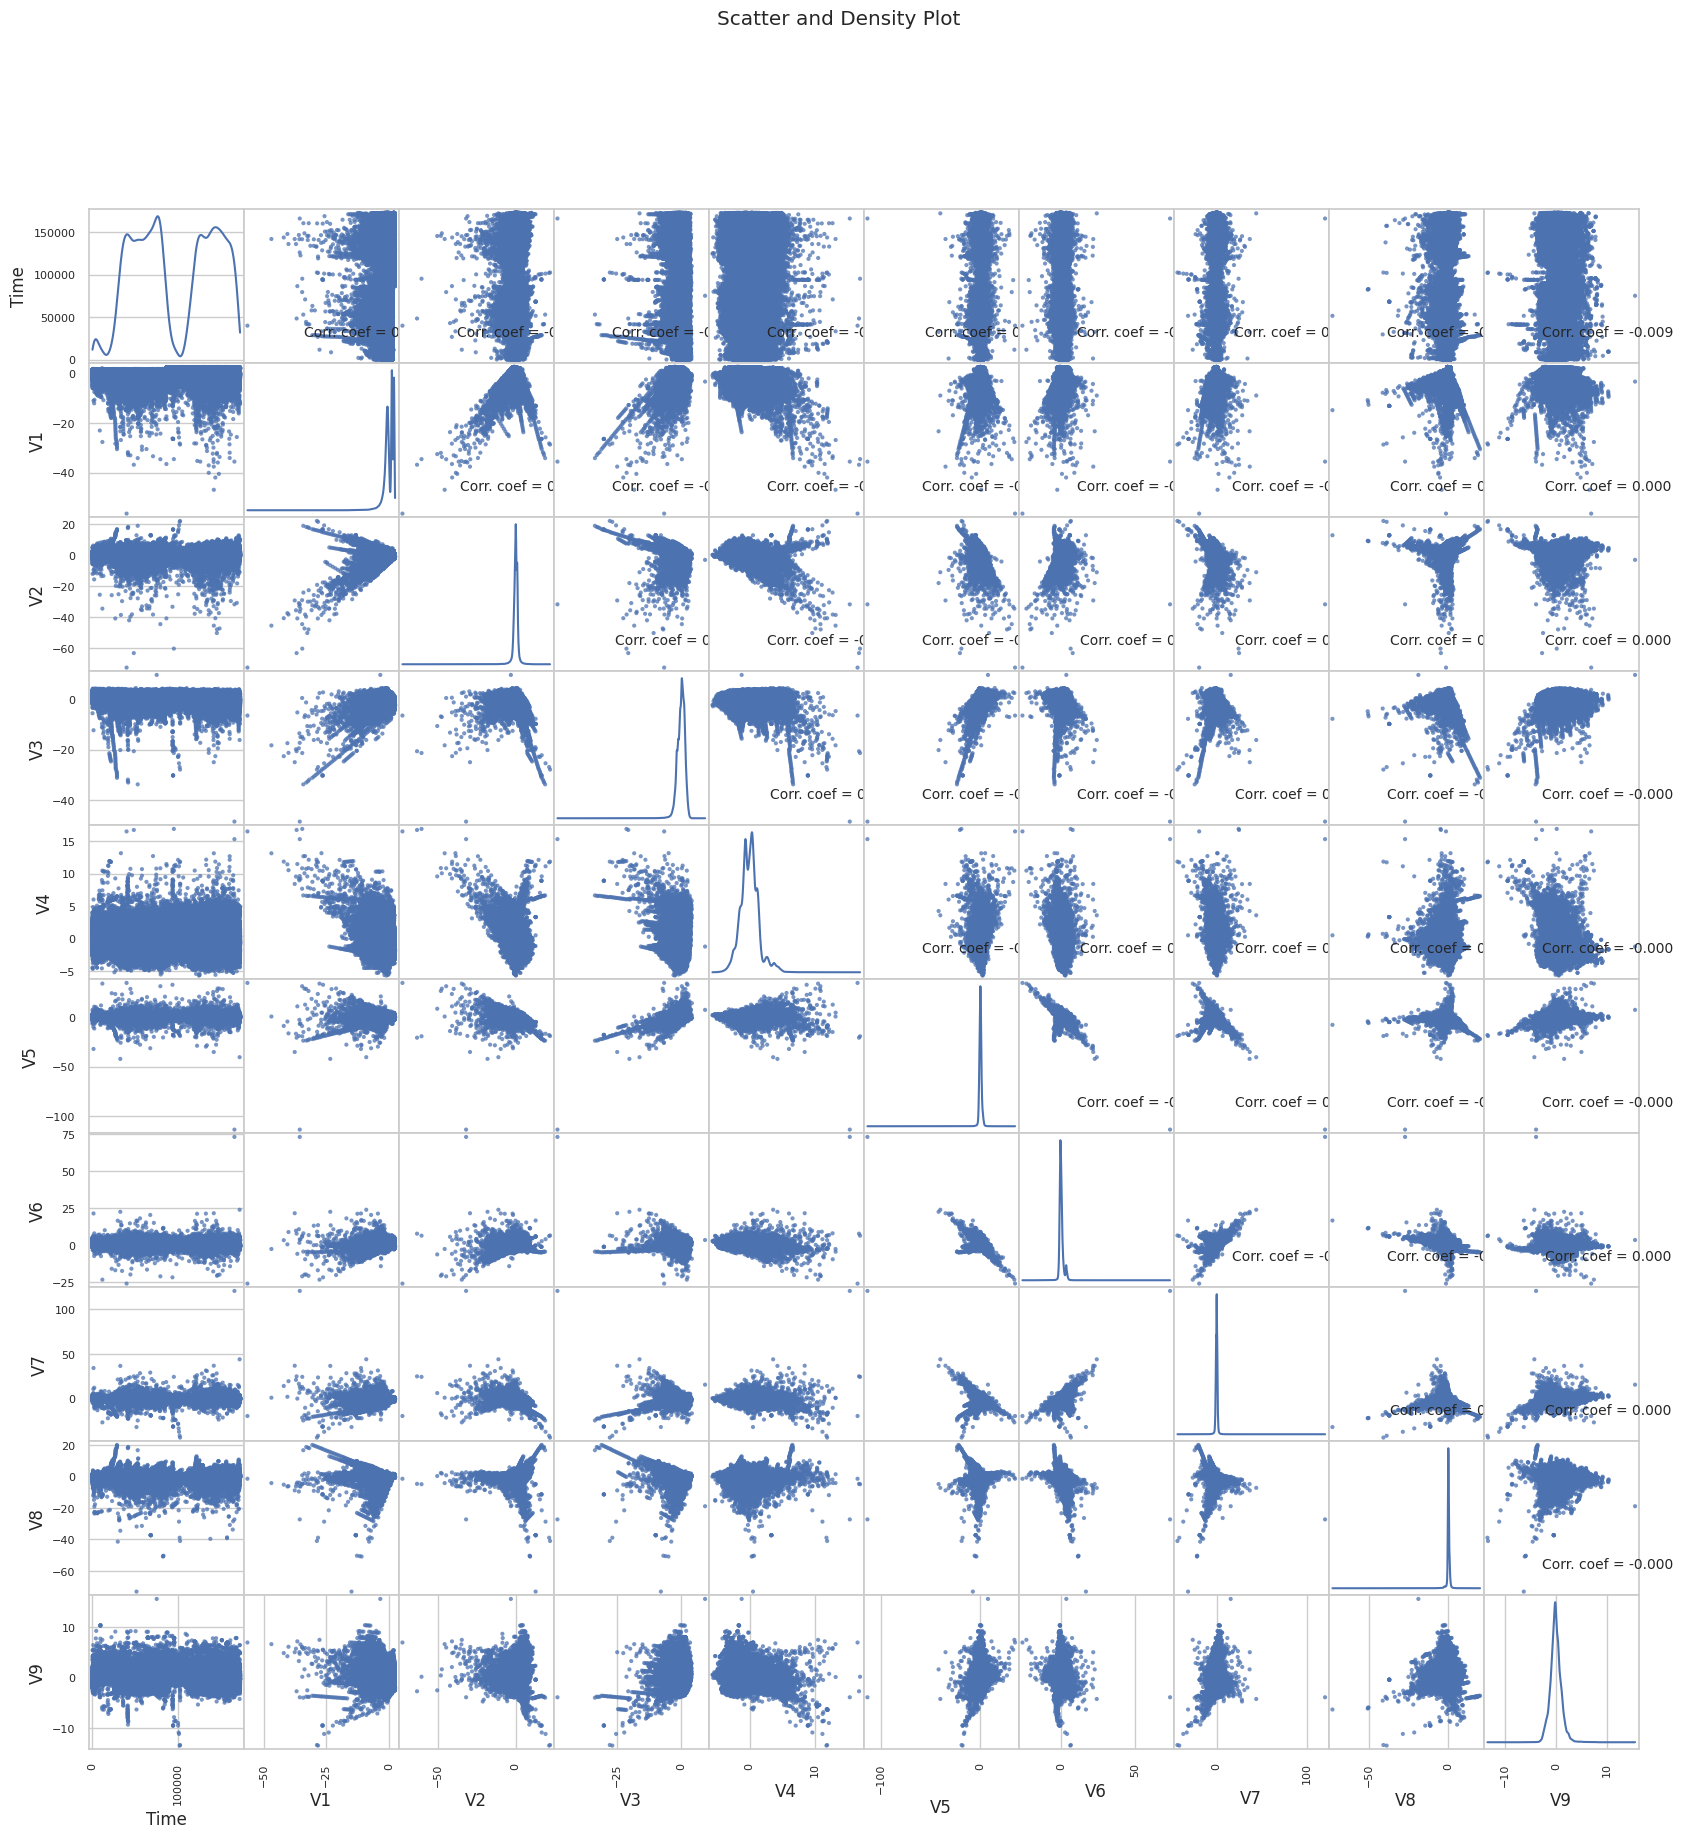

In [10]:
plotScatterMatrix(df1, 20, 10)



```
p = df1.hist(figsize=(20,20))
```



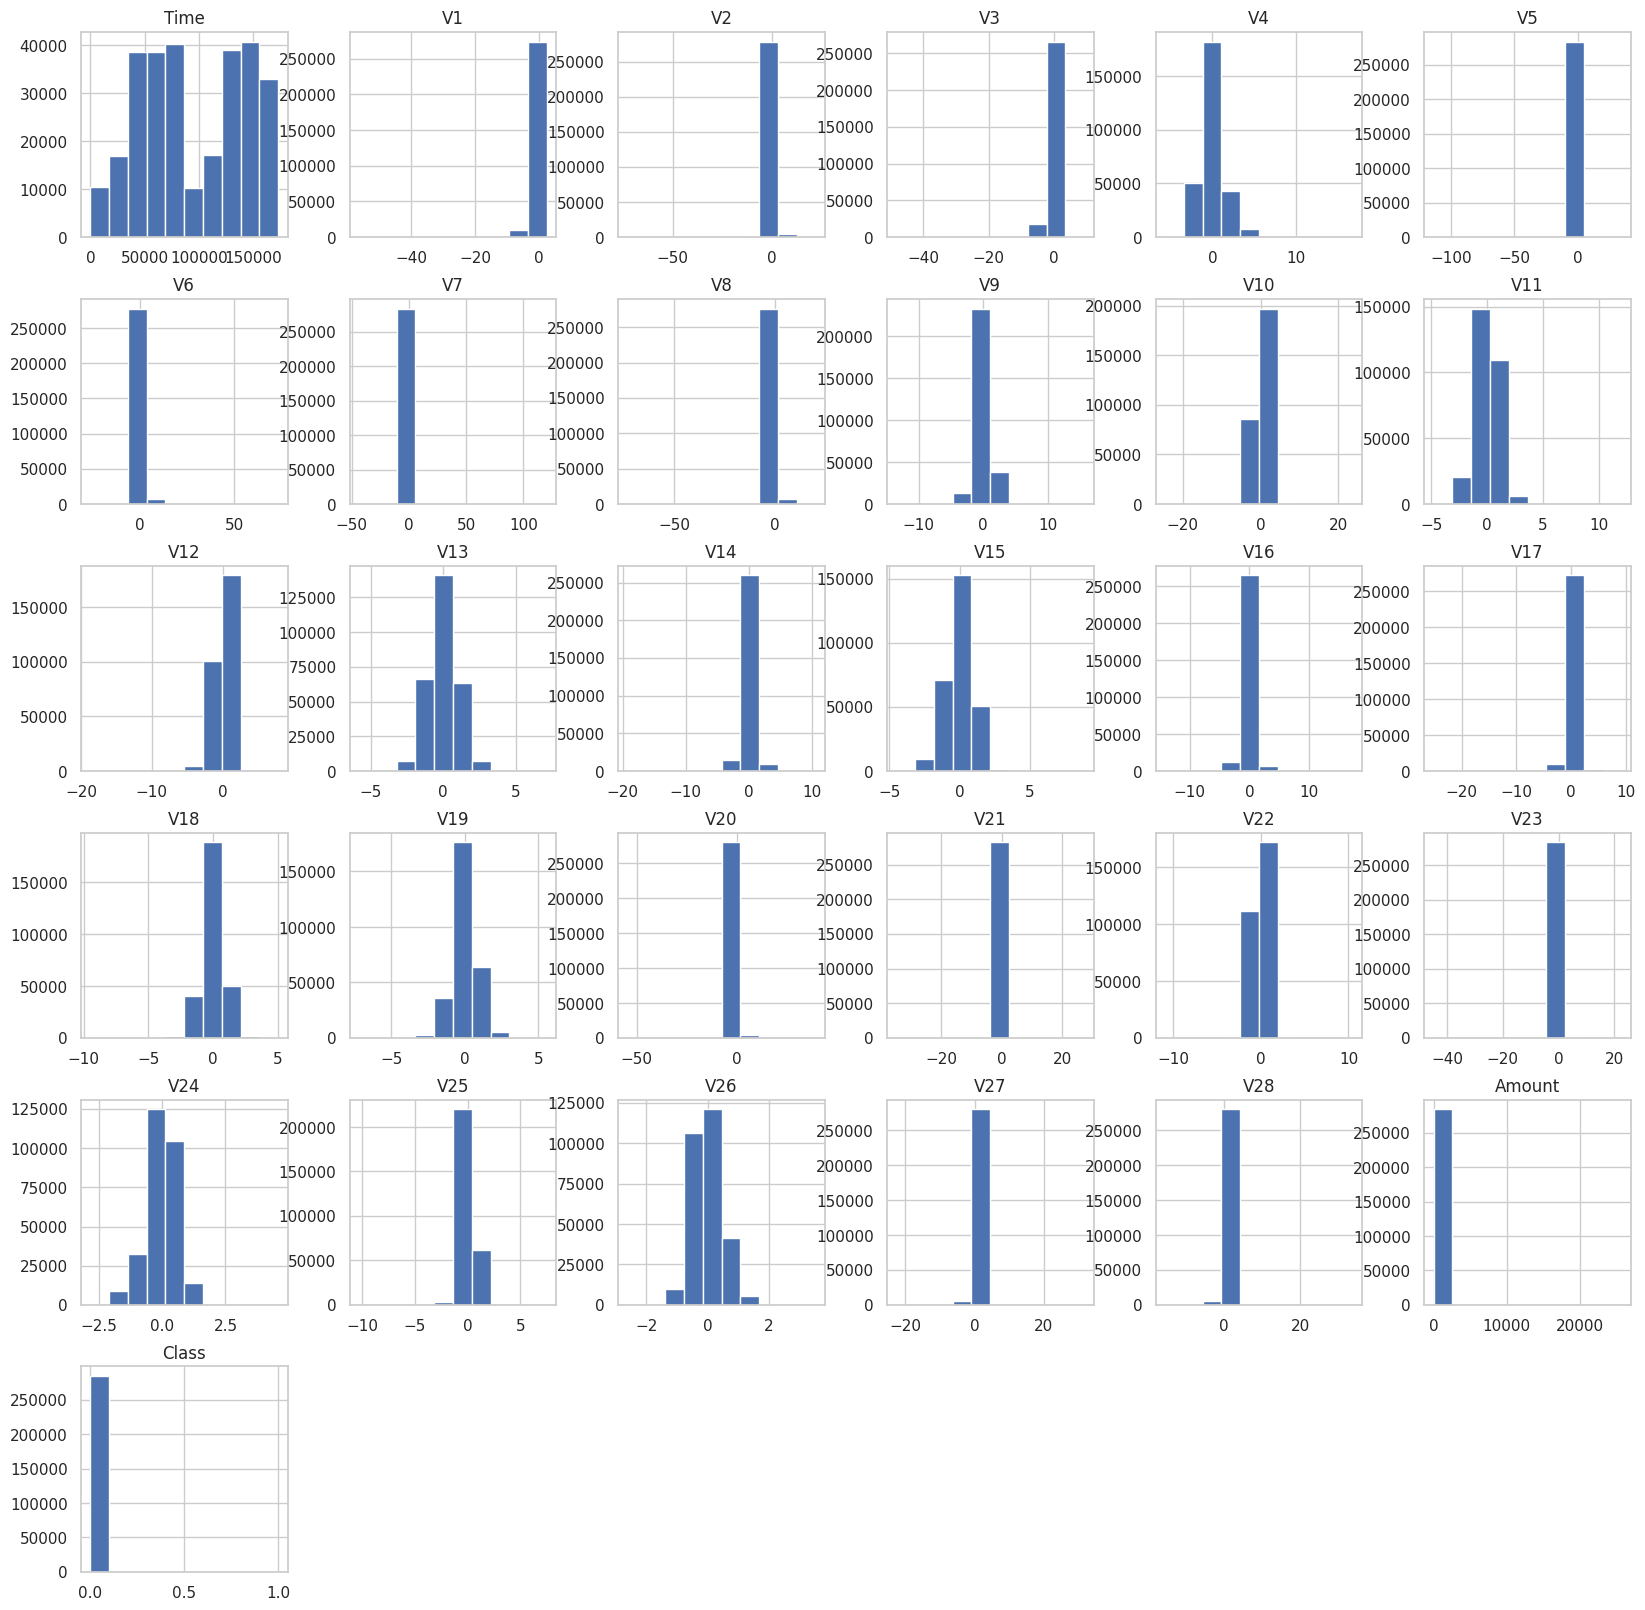

In [11]:
p = df1.hist(figsize=(20,20))

## Renaming columns



```
# let's quickly convert the columns to lower case and rename the Class column
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()
```



In [12]:
df.columns = map(str.lower, df.columns) # convert the columns to lower case
df.rename(columns={'class': 'label'}, inplace=True) # rename class as label
df.head() # first 5 rows

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Calculated field: log10(amount)

Turn the amount feature into a normally distributed log equivalent.



```
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)
```



In [13]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)



```
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] +
    ['log10_amount', 'label']
]
```



In [14]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] +
    ['log10_amount', 'label']
]

let's see the data-set

```
df
```



In [15]:
df

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,log10_amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,2.174990,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.429754,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,2.578249,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,2.091667,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1.845036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,-0.113504,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,1.394277,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,1.831742,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,1.000000,0


<a id="3"></a> <br>
# Visualising clusters with t-SNE
*t-Distributed Stochastic Neighbor Embedding (t-SNE)*

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): <br>
> t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: **t-SNE is a dimensionality reduction technique used for visualisations** of complex datasets.
It **maps clusters in high-dimensional data** to **a two- or three dimensional plane** so we can get an idea of how easy it will be to **discriminate between classes**.
It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

A more elaborate [introduction](https://www.datacamp.com/community/tutorials/introduction-t-sne) is available on DataCamp.

For academic detailed explanation please go to: L.J.P. van der Maaten and G.E. Hinton. **Visualizing High-Dimensional Data Using t-SNE.** Journal of Machine Learning Research 9(Nov):2579-2605, 2008. https://lvdmaaten.github.io/tsne/


## Undersampling the non-fraud
To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).



```
# manual parameter
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values
```



In [16]:
# manual parameter
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(int(len(fraud) * RATIO_TO_FRAUD), random_state=RANDOM_SEED)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features, labels = visualisation_initial.drop('label', axis=1).values, visualisation_initial.label.values



```
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")
```



In [17]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to fraud.


## t-SNE output


Let's look at another dimensionality reduction technique called t-SNE (t-Distributed Stochastic Neighbor Embedding).

THIS PROCESS WILL TAKE ABOUT 2-3 MINUTES



```
from sklearn.manifold import TSNE
# A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely)
#how to balance attention between local and global aspects of your data. The parameter is,
#in a sense, a guess about the number of close neighbors each point has. The perplexity
# value has a complex effect on the resulting pictures.

# tsne = TSNE(n_components=2, perplexity=30)
tsne = TSNE(n_components=2, perplexity=50)
features_embedded = tsne.fit_transform(features)
```



In [18]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
# A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely)
# how to balance attention between local and global aspects of your data. The parameter is,
# in a sense, a guess about the number of close neighbors each point has. The perplexity
# value has a complex effect on the resulting pictures.

# tsne = TSNE(n_components=2, perplexity=30)
tsne = TSNE(n_components=2, perplexity=50)
features_embedded = tsne.fit_transform(features)

Now lets plot this figure using 2 or 3D scatter plot using plotly

https://plotly.com/python/line-and-scatter/
https://plotly.com/python/3d-scatter-plots/




```
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=features_embedded[np.where(labels==1)][:,0],
                         y=features_embedded[np.where(labels==1)][:,1],
                        mode='markers',
                        name='Fraud'))
fig.add_trace(go.Scatter(x=features_embedded[np.where(labels==0)][:,0],
                         y=features_embedded[np.where(labels==0)][:,1],
                        mode='markers',
                        name='No Fraud'))
fig.show()
```



In [19]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = features_embedded[np.where(labels==1)][:,0],
                         y = features_embedded[np.where(labels==1)][:,1],
                         mode = 'markers',
                         name ='Fraud'))
fig.add_trace(go.Scatter(x = features_embedded[np.where(labels==0)][:,0],
                         y = features_embedded[np.where(labels==0)][:,1],
                         mode = 'markers',
                         name = 'Clean'))
fig.show()

3D TSNE

**Warning! This code can take up to 7 minutes**




```
from sklearn.manifold import TSNE

# A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely)
#how to balance attention between local and global aspects of your data. The parameter is,
#in a sense, a guess about the number of close neighbors each point has. The perplexity
# value has a complex effect on the resulting pictures.

# tsne = TSNE(n_components=2, perplexity=30)
tsne = TSNE(n_components=3, perplexity=50)  # Perperxity is related to the number of ne
features_embedded = tsne.fit_transform(features)
```



In [20]:
from sklearn.manifold import TSNE
# A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely)
# how to balance attention between local and global aspects of your data. The parameter is,
# in a sense, a guess about the number of close neighbors each point has. The perplexity
# value has a complex effect on the resulting pictures.

# tsne = TSNE(n_components=2, perplexity=30)
tsne = TSNE(n_components=3, perplexity=50)  # Perperxity is related to the number of ne
features_embedded = tsne.fit_transform(features)



```
import plotly.express as px
#df = px.data.iris()
#fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
#              color='species')
#fig.show()

import plotly.graph_objects as go
fig3d = go.Figure()
fig3d.add_trace(go.Scatter3d(x=features_embedded[np.where(labels==1)][:,0], y=features_embedded[np.where(labels==1)][:,1],z=features_embedded[np.where(labels==1)][:,2],mode='markers',name='Fraud'))
fig3d.add_trace(go.Scatter3d(x=features_embedded[np.where(labels==0)][:,0], y=features_embedded[np.where(labels==0)][:,1],z=features_embedded[np.where(labels==1)][:,2],mode='markers',name='No Fraud'))
fig3d.show()
```



In [21]:
# import plotly.express as px
# df = px.data.iris()
# fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
#              color='species')
# fig.show()

import plotly.graph_objects as go
fig3d = go.Figure()
fig3d.add_trace(go.Scatter3d(x = features_embedded[np.where(labels==1)][:,0],
                             y = features_embedded[np.where(labels==1)][:,1],
                             z = features_embedded[np.where(labels==1)][:,2],
                             mode = 'markers',
                             name = 'Fraud'))
fig3d.add_trace(go.Scatter3d(x = features_embedded[np.where(labels==0)][:,0],
                             y = features_embedded[np.where(labels==0)][:,1],
                             z = features_embedded[np.where(labels==1)][:,2],
                             mode = 'markers',
                             name = 'Clean'))
fig3d.show()

Some clusters are apparent, but a minority of fraud transactions remains sneaky, sneaky.

<a id="4"></a> <br>
# Train/Validate/Test split
Our auto-encoder will **only train on transactions that were normal**.
What's left over will be combined with the fraud set to form our test sample.

We will be doing something akin to the below:

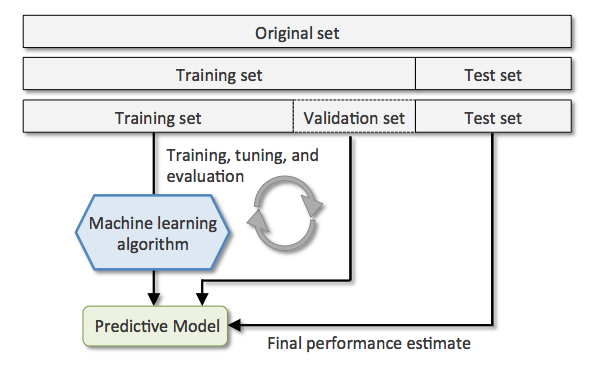


1. Training: only non-fraud
    * Split into:
        1. Actual training of our autoencoder
        2. Validation of the neural network's ability to generalize
2. Testing: mix of fraud and non-fraud
    * Treated like new data
    * Attempt to locate outliers
        1. Compute reconstruction loss
        2. Apply threshold

### Shuffle the samples

First we will shuffle the samples using the command `DataFrame.sample(frac=1)`. But first we will separate the Fraud samples as we don't want them to be part of our training.



```
# Split Fraud and Clean

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

Data_Fraud_df=fraud.drop(['label'], axis=1)
Data_Clean_df=clean.drop(['label'], axis=1)

# Shuffle the samples before split
Data_Clean_df=Data_Clean_df.sample(frac=1)
# Convert into array
Data_Clean=Data_Clean_df.values
Data_Fraud=Data_Fraud_df.values
```



In [22]:
# Split Fraud and Clean

# Splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]
Data_Fraud_df = fraud.drop(['label'], axis=1)
Data_Clean_df = clean.drop(['label'], axis=1)

# Shuffle the clean samples before split
Data_Clean_df = Data_Clean_df.sample(frac=1)

# Convert into array
Data_Clean = Data_Clean_df.values
Data_Fraud = Data_Fraud_df.values



```
# Split Clean intop test, val, and train
n_samples,n_variables=Data_Clean.shape;
train_samples=int(n_samples*.6)
val_samples=int(n_samples*.3)

Data_train=Data_Clean[:train_samples];
Data_val=Data_Clean[train_samples:train_samples+val_samples];
Data_test=Data_Clean[train_samples+val_samples:];
```



In [23]:
# Split Clean into train, val, test
n_samples, n_variables = Data_Clean.shape # array.shape: (rows, cols)
train_samples = int(n_samples*0.6) # 60% for training
val_samples = int(n_samples*0.3) # 30% for validation
# 10% for testing

Data_train = Data_Clean[:train_samples]
Data_val = Data_Clean[train_samples: train_samples + val_samples]
Data_test = Data_Clean[train_samples + val_samples:]

# Autoencoder
Now we build the autoencoder

### Import packages

```
#@title Import packages
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
```



In [24]:
# @title Import packages
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.models import load_model

### Define Autoencoder

```
#@title Define Autoencoder
x_train=Data_train; x_val=Data_val; x_test=Data_test;


n_samples,n_features=np.shape(x_train);
bottleneck_size =3;
#cone=[512,128,64];
cone=[16,8,4];

input_img = Input(shape=(n_features,))

encoded = Dense(cone[0], activation='relu')(input_img)
encoded = Dense(cone[1], activation='relu')(encoded)
encoded = Dense(cone[2], activation='relu')(encoded)
encoded = Dense(bottleneck_size, activation='linear')(encoded)
encoder = Model(input_img, encoded)


encoded_input = Input(shape=(bottleneck_size,))
decoded = Dense(cone[2], activation='relu')(encoded_input)
decoded = Dense(cone[1], activation='relu')(decoded)
decoded = Dense(cone[0], activation='relu')(decoded)
decoded = Dense(n_features, activation='sigmoid')(decoded)
decoder = Model(encoded_input, decoded)

full = decoder(encoder(input_img))
ae = Model(input_img, full)
ae.compile(optimizer='adam', loss='mean_squared_error')
```



Sigmoid Function Formula: $\sigma(x) = \frac{1}{1 + e^{-x}}$

In [25]:
# @title Define Autoencoder
x_train = Data_train
x_val = Data_val
x_test = Data_test
n_samples, n_features = np.shape(x_train) # shape: (rows, cols)
bottleneck_size = 3

# cone = [512,128,64]
cone = [16,8,4]

# encoding
input_img = Input(shape=(n_features,)) # input layer with 29 neurons
encoded = Dense(cone[0], activation='relu')(input_img) # hidden dense layer with 16 neurons using the relu activation
encoded = Dense(cone[1], activation='relu')(encoded) # hidden dense layer with 8 neurons using the relu activation
encoded = Dense(cone[2], activation='relu')(encoded) # hidden dense layer with 4 neurons using the relu activation
encoded = Dense(bottleneck_size, activation='linear')(encoded) # output dense layer with 3 neurons using the linear activation
encoder = Model(input_img, encoded) # input = input_img, output = encoded

# decoding
encoded_input = Input(shape=(bottleneck_size,)) # input layer with 3 neurons
decoded = Dense(cone[2], activation='relu')(encoded_input) # hidden dense layer with 4 neurons using the relu activation
decoded = Dense(cone[1], activation='relu')(decoded) # hidden dense layer with 8 neurons using the relu activation
decoded = Dense(cone[0], activation='relu')(decoded) # hidden dense layer with 16 neurons using the relu activation
decoded = Dense(n_features, activation='sigmoid')(decoded) # output dense layer with 29 neurons using the sigmoid activation
decoder = Model(encoded_input, decoded)

full = decoder(encoder(input_img))
ae = Model(input_img, full)
ae.compile(optimizer='adam', loss='mean_squared_error') # adam: adaptive moment estimation; loss function is MSE

### Training Autoencoder

```
#@title Training Autoencoder
AE_Training_History=ae.fit(x_train, x_train,
    epochs = 10,
    batch_size=256,
    validation_data=(x_val, x_val))

save_model=False
if save_model:
    ae.save('model.h5')
    encoder.save('encoder.h5')
    decoder.save('decoder.h5')
```



In [26]:
# @title Training Autoencoder
AE_Training_History = ae.fit(x_train, # training features
                             x_train, # training labels
                             epochs = 10, # the model will iterate over the training data 10 times
                             batch_size = 256, # the model will update its weights after processing every 32 samples
                             validation_data = (x_val, x_val)) # the model will evaluate its performance on the validation set after each epoch

save_model = False # not save model
if save_model:
    ae.save('model.h5')
    encoder.save('encoder.h5')
    decoder.save('decoder.h5')

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1481 - val_loss: 0.9570
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9569 - val_loss: 0.9195
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9298 - val_loss: 0.9098
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9222 - val_loss: 0.9029
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9179 - val_loss: 0.8987
Epoch 6/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9111 - val_loss: 0.8949
Epoch 7/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9079 - val_loss: 0.8921
Epoch 8/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9053 - val_loss: 0.8904
Epoch 9/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9033 - val_loss: 0.8882
Epoch 10/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9015 - val_loss: 0.8866


### Run Autoencoder over Test Set

```
#@title Run Autoencoder over Test Set

x_comp=np.concatenate((x_test,Data_Fraud),axis=0)
y_comp=np.concatenate((np.zeros([len(x_test[:,0]),]),np.ones([len(Data_Fraud[:,0]),])),axis=0)

encoded_data = encoder.predict(x_comp)
decoded_data = decoder.predict(encoded_data)
```



In [27]:
# @title Run Autoencoder over Test Set
x_comp = np.concatenate((x_test, Data_Fraud), axis=0)
y_comp = np.concatenate((np.zeros([len(x_test[:,0]),]), np.ones([len(Data_Fraud[:,0]),])), axis=0) # axis=0: operate along rows vertically, increase the number of rows

encoded_data = encoder.predict(x_comp)
decoded_data = decoder.predict(encoded_data)

904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


### Training Statistics

```
#@title Training Statistics
# list all data in history
print(AE_Training_History.history.keys())
# visualization of the loss minimization during the training process
plt.plot(AE_Training_History.history['loss'])
plt.plot(AE_Training_History.history['val_loss'])
plt.title('Autoencoder Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
```



dict_keys(['loss', 'val_loss'])


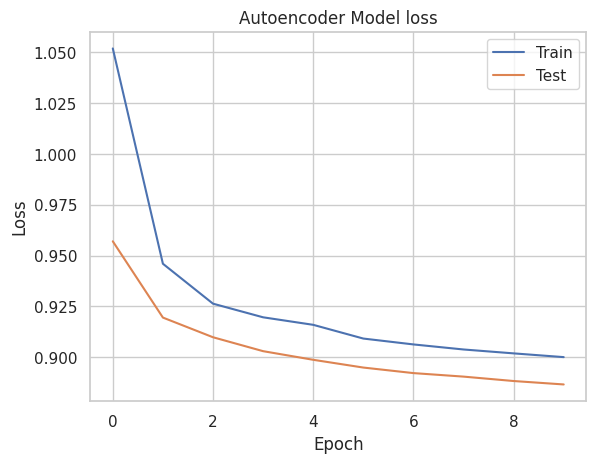

In [28]:
# @title Training Statistics
# list all data in history
print(AE_Training_History.history.keys())

# visualization of the loss minimization during the training process
plt.plot(AE_Training_History.history['loss']) # Train
plt.plot(AE_Training_History.history['val_loss']) # Test
plt.title('Autoencoder Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Latent Space Representation

```
#@title Latent Space Representation
import plotly.graph_objects as go
fig = go.Figure()
for i in range(len(np.unique(y_comp))):
    if bottleneck_size==2:
        fig.add_trace(go.Scatter(x=encoded_data[np.where(y_comp==i)][:,0], y=encoded_data[np.where(y_comp==i)][:,1],mode='markers',name=str(i)))
    else:
        fig.add_trace(go.Scatter3d(x=encoded_data[np.where(y_comp==i)][:,0], y=encoded_data[np.where(y_comp==i)][:,1],z=encoded_data[np.where(y_comp==i)][:,2],mode='markers',name=str(i)))


fig.show()
```



In [29]:
# @title Latent Space Representation
import plotly.graph_objects as go

fig = go.Figure()
for i in range(len(np.unique(y_comp))):
    if bottleneck_size == 2:
        fig.add_trace(go.Scatter(x = encoded_data[np.where(y_comp==i)][:,0],
                                 y = encoded_data[np.where(y_comp==i)][:,1],
                                 mode = 'markers',
                                 name = str(i)))
    else:
        fig.add_trace(go.Scatter3d(x = encoded_data[np.where(y_comp==i)][:,0],
                                   y = encoded_data[np.where(y_comp==i)][:,1],
                                   z = encoded_data[np.where(y_comp==i)][:,2],
                                   mode = 'markers', # specify how data points are displayed in the plot, 'lines', 'lines+markers'
                                   name = str(i)))

fig.show()

# <font color='blue'> Evaluate the losses or the error for `Clean` and `Fraud` transactions

### <font color='blue'>1. Calculate the RMSE, or Root Mean Square Error for every sample for both classses separately

In [33]:
# Calculate RMSE for every sample
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2, axis=1))

# Function to print and return RMSE for a given dataset
def print_and_return_rmse(data, name):

    # Predict encoded and decoded (reconstructed) data
    encoded_data = encoder.predict(data)
    decoded_data = decoder.predict(encoded_data)

    # Calculate RMSE for every sample
    rmse_values = calculate_rmse(data, decoded_data)

    # Output RMSE values
    print(f"RMSE for {name}: RMSE = {rmse_values}")
    return rmse_values

# Print and return RMSE values for every sample for both classes
# For Clean (label = 0)
rmse_clean = print_and_return_rmse(Data_Clean, 'Clean')

8885/8885 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
RMSE for Clean: RMSE = [0.48964678 0.90120848 0.52223283 ... 0.93331518 0.67376338 0.5844032 ]


In [34]:
# For Fraud (label = 1)
rmse_fraud = print_and_return_rmse(Data_Fraud, 'Fraud')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE for Fraud: RMSE = [ 2.12534521  1.31528722  2.03821992  4.18069453  2.73362755  3.72604853
  3.70773925  3.33659184  3.33128042  3.01054343  3.14383312  2.5190381
  2.97717297  3.00206432  3.43177483  4.17200495  4.14208129  3.58715407
  3.54194373  3.46542211  3.46435054  4.21866167  4.17751424  4.17733083
  3.27766114  7.72712714  3.32115587  7.39983447  7.73584419  3.42954156
  4.32195599  4.19070949  2.70010506  7.79910829  7.4289254   7.7804502
  7.86052938  7.89243295  2.62906929  0.87526897  0.90371845  0.87908298
  7.92929131  7.64985448  8.93348985  8.42160996  8.08944664  8.48417036
  8.58663445  8.65920447  8.73650305  8.81840126  8.90476876  8.99547421
  9.09038577  9.18937156  1.18551105  8.04602447  8.14722223  8.27963363
  1.03163885  8.54715751  8.69040673  8.83705712  8.98690405  9.13979032
  9.295566    9.45408828  9.61522133  9.77883611  9.94481014 10.11302728
 10.28337746  2.0167337

Since the autoencoder was trained only on normal data, the RMSEs for fraud data are *higher* than the RMSEs for clean data, which indicates it is difficult for the autoencoder to reconstruct the fraud data, so it can be used for anomaly detection.

### <font color='blue'>2. Represent the results in 2 overlapped histograms (one histogram for each class)

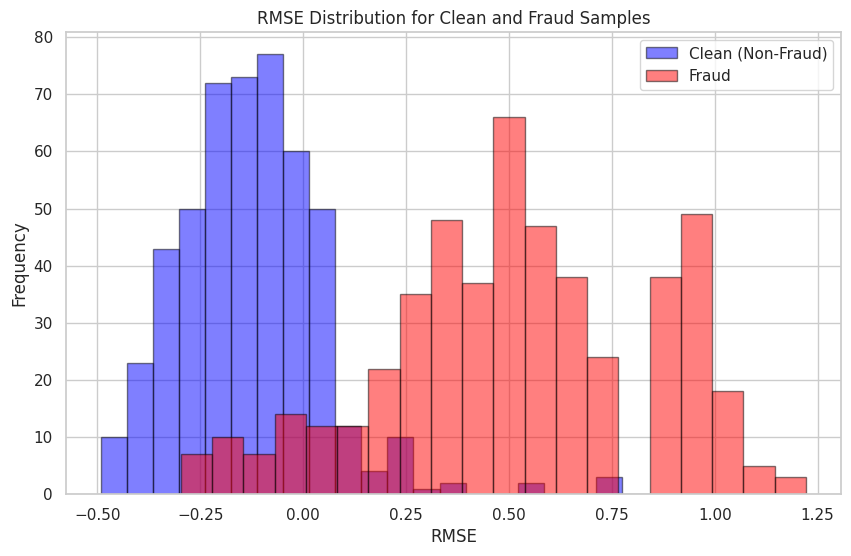

In [31]:
# frequency of rmse_clean is too large to see the histogram of rmse_fraud
# so random select len(rmse_fraud) number of samples from rmse_fraud
np.random.seed(20020215)
rmse_clean_sampled = np.random.choice(rmse_clean, size=len(rmse_fraud), replace=False)

# Plotting the histograms for both classes
plt.figure(figsize=(10, 6))
plt.hist(np.log10(rmse_clean_sampled), bins=20, alpha=0.5, label='Clean (Non-Fraud)', color='blue', edgecolor='black')
plt.hist(np.log10(rmse_fraud), bins=20, alpha=0.5, label='Fraud', color='red', edgecolor='black')

# Adding titles and labels
plt.title('RMSE Distribution for Clean and Fraud Samples')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

From the overlapped histograms, it is clear that RMSE values of the Fraud dataset are *higher* than RMSE values of the Clean dataset.

### <font color='blue'>3. Calculate the mean and the standard deviation of the errors for both classes

In [32]:
# Function to print mean and std for rmse values
def print_mean_std_for_rmse(data, name):

    # Predict encoded and decoded (reconstructed) data
    encoded_data = encoder.predict(data)
    decoded_data = decoder.predict(encoded_data)

    # Calculate RMSE for every sample
    rmse_values = calculate_rmse(data, decoded_data)

    # Output RMSE mean and std
    print(f"RMSE for {name}: Mean = {np.mean(rmse_values)}, Std = {np.std(rmse_values)}")

# Print mean and standard deviation of RMSE values for both classes
# For Clean (label = 0)
rmse_clean_mean_std = print_mean_std_for_rmse(Data_Clean, 'Clean')
# For Fraud (label = 1)
rmse_fraud_mean_std = print_mean_std_for_rmse(Data_Fraud, 'Fraud')

8885/8885 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
RMSE for Clean: Mean = 0.8046816817498472, Std = 0.49866598860123923
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE for Fraud: Mean = 4.2239785842373365, Std = 3.026842875369071
